The dataset used in this notebook is [2018 Data Science Bowl](https://www.kaggle.com/competitions/data-science-bowl-2018/data)

In [2]:
from Unet import *
import numpy as np
import matplotlib.pyplot as plt 
import os 
from tqdm import tqdm
from skimage.io import imread, imshow
from skimage.transform import resize 
import random
import pandas as pd

In [32]:
IMG_WIDTH, IMG_HEIHGT, IMG_DEPTH = (128,128,3)
TRAIN_PATH = 'stage1_train/' 
TEST_PATH = 'stage1_test/'

train_ids = next(os.walk(TRAIN_PATH))[1] # index the subdir names 
test_ids = next(os.walk(TEST_PATH))[1]



In [78]:
X_train = np.zeros((len(train_ids), IMG_WIDTH, IMG_HEIHGT, IMG_DEPTH), dtype=np.uint8)
Y_train = np.zeros((len(train_ids), IMG_WIDTH, IMG_HEIHGT, 1), dtype=bool)

for n, id_ in tqdm(enumerate(train_ids), total = len(train_ids)):
    path = TRAIN_PATH + id_  # the whole pass
    img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_DEPTH] 
    img = resize(img, (IMG_HEIHGT,IMG_WIDTH), mode = 'constant', preserve_range = True)
    X_train[n] = img
    mask = np.zeros((IMG_HEIHGT, IMG_WIDTH,1), dtype=bool)
    for mask_file in next(os.walk(path + '/masks/'))[2]: # index the subfile names 
        mask_ = imread(path + '/masks/' + mask_file)
        mask_ = np.expand_dims(resize(mask_, (IMG_HEIHGT,IMG_WIDTH), mode = 'constant', preserve_range = True), axis = -1)
        mask = np.maximum(mask, mask_) # overlay the masks on each other    
    Y_train[n] = mask

100%|██████████| 670/670 [06:33<00:00,  1.70it/s]


In [79]:
X_test = np.zeros((len(test_ids), IMG_WIDTH, IMG_HEIHGT, IMG_DEPTH), dtype=np.uint8)
test_sizes = list()
for n, id_ in tqdm(enumerate(test_ids), total = len(test_ids)):
    path = TEST_PATH + id_  # the whole pass
    img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_DEPTH]
    test_sizes.append(img.shape) # saving the original sizes so that we can superimpose the segmentations on the original image   
    img = resize(img, (IMG_HEIHGT,IMG_WIDTH), mode = 'constant', preserve_range = True)
    X_test[n] = img


100%|██████████| 65/65 [00:01<00:00, 41.02it/s]


(-0.5, 127.5, 127.5, -0.5)

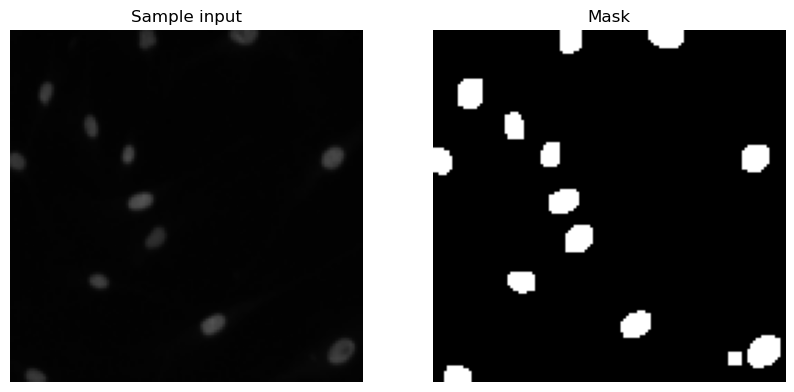

In [84]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
ind = np.random.randint(0, len(train_ids))
axes[0].imshow(X_train[ind])
axes[0].set_title('Sample input')
axes[0].axis('off')

axes[1].imshow(np.squeeze(Y_train[ind]), cmap='gray')
axes[1].set_title('Mask')
axes[1].axis('off')  

In [86]:
seed = 42
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

model = build_Unet(IMG_WIDTH, IMG_HEIHGT, IMG_DEPTH)
model.compile(optimizer = "adam", loss= "binary_crossentropy", metrics = ["accuracy"])
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_3 (Lambda)   │ (None, 128, 128,  │          0 │ input_layer_3[0]… │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_57 (Conv2D)  │ (None, 128, 128,  │        448 │ lambda_3[0][0]    │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_27          │ (None, 128, 128,  │          0 │ conv2d_57[0][0]   │
│ (Dropout)           │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_58 (Conv2D)  │ (None, 128, 128,  │      2,320 │ dropout_27[0][0]  │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_12    │ (None, 64, 64,    │          0 │ conv2d_58[0][0]   │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_59 (Conv2D)  │ (None, 64, 64,    │      4,640 │ max_pooling2d_12… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_28          │ (None, 64, 64,    │          0 │ conv2d_59[0][0]   │
│ (Dropout)           │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_60 (Conv2D)  │ (None, 64, 64,    │      9,248 │ dropout_28[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_13    │ (None, 32, 32,    │          0 │ conv2d_60[0][0]   │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_61 (Conv2D)  │ (None, 32, 32,    │     18,496 │ max_pooling2d_13… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_29          │ (None, 32, 32,    │          0 │ conv2d_61[0][0]   │
│ (Dropout)           │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_62 (Conv2D)  │ (None, 32, 32,    │     36,928 │ dropout_29[0][0]  │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_14    │ (None, 16, 16,    │          0 │ conv2d_62[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_63 (Conv2D)  │ (None, 16, 16,    │     73,856 │ max_pooling2d_14… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_30          │ (None, 16, 16,    │          0 │ conv2d_63[0][0]   │
│ (Dropout)           │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_64 (Conv2D)  │ (None, 16, 16,    │    147,584 │ dropout_30[0][0]

 Total params: 1,941,105 (7.40 MB)

 Trainable params: 1,941,105 (7.40 MB)

 Non-trainable params: 0 (0.00 B)

## Training the Model 

In [88]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=2, monitor="val_loss"), 
    tf.keras.callbacks.TensorBoard(log_dir = "logs")
]

history = results = model.fit(X_train, Y_train, validation_split=0.1, batch_size=16, epochs=25, callbacks=callbacks)

Epoch 1/25
38/38 ━━━━━━━━━━━━━━━━━━━━ 18s 301ms/step - accuracy: 0.6946 - loss: 0.6476 - val_accuracy: 0.8049 - val_loss: 0.3551
Epoch 2/25
38/38 ━━━━━━━━━━━━━━━━━━━━ 11s 289ms/step - accuracy: 0.8304 - loss: 0.3454 - val_accuracy: 0.9198 - val_loss: 0.1983
Epoch 3/25
38/38 ━━━━━━━━━━━━━━━━━━━━ 11s 287ms/step - accuracy: 0.9226 - loss: 0.2087 - val_accuracy: 0.9469 - val_loss: 0.1341
Epoch 4/25
38/38 ━━━━━━━━━━━━━━━━━━━━ 11s 296ms/step - accuracy: 0.9432 - loss: 0.1531 - val_accuracy: 0.9506 - val_loss: 0.1235
Epoch 5/25
38/38 ━━━━━━━━━━━━━━━━━━━━ 11s 302ms/step - accuracy: 0.9487 - loss: 0.1391 - val_accuracy: 0.9551 - val_loss: 0.1138
Epoch 6/25
38/38 ━━━━━━━━━━━━━━━━━━━━ 11s 294ms/step - accuracy: 0.9522 - loss: 0.1308 - val_accuracy: 0.9588 - val_loss: 0.1062
Epoch 7/25
38/38 ━━━━━━━━━━━━━━━━━━━━ 11s 287ms/step - accuracy: 0.9544 - loss: 0.1246 - val_accuracy: 0.9614 - val_loss: 0.0988
Epoch 8/25
38/38 ━━━━━━━━━━━━━━━━━━━━ 11s 285ms/step - accuracy: 0.9558 - loss: 0.1207 - val_accu

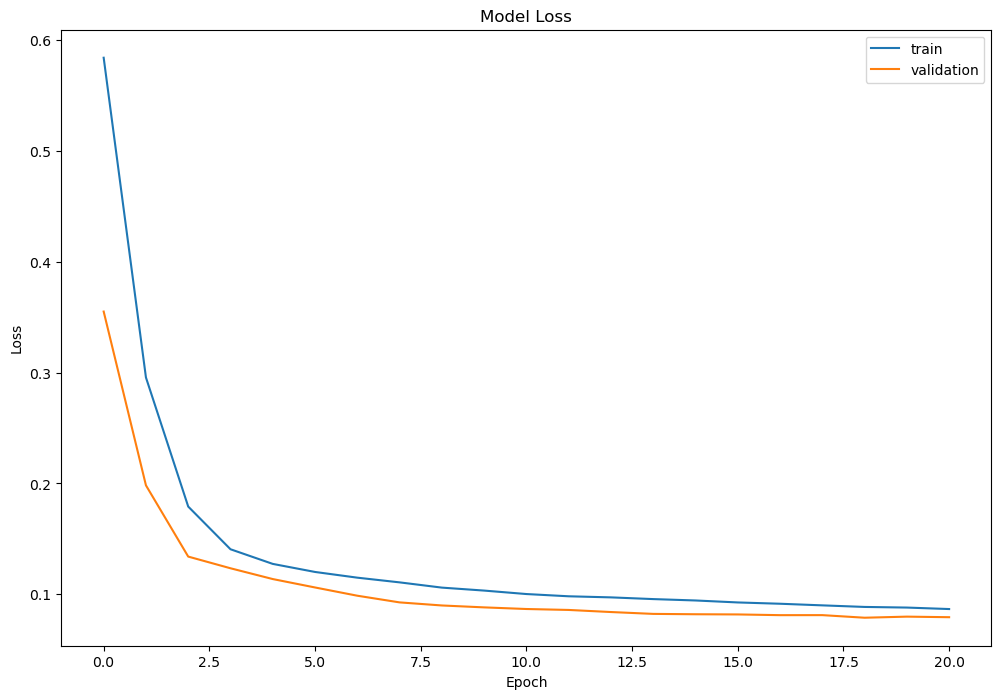

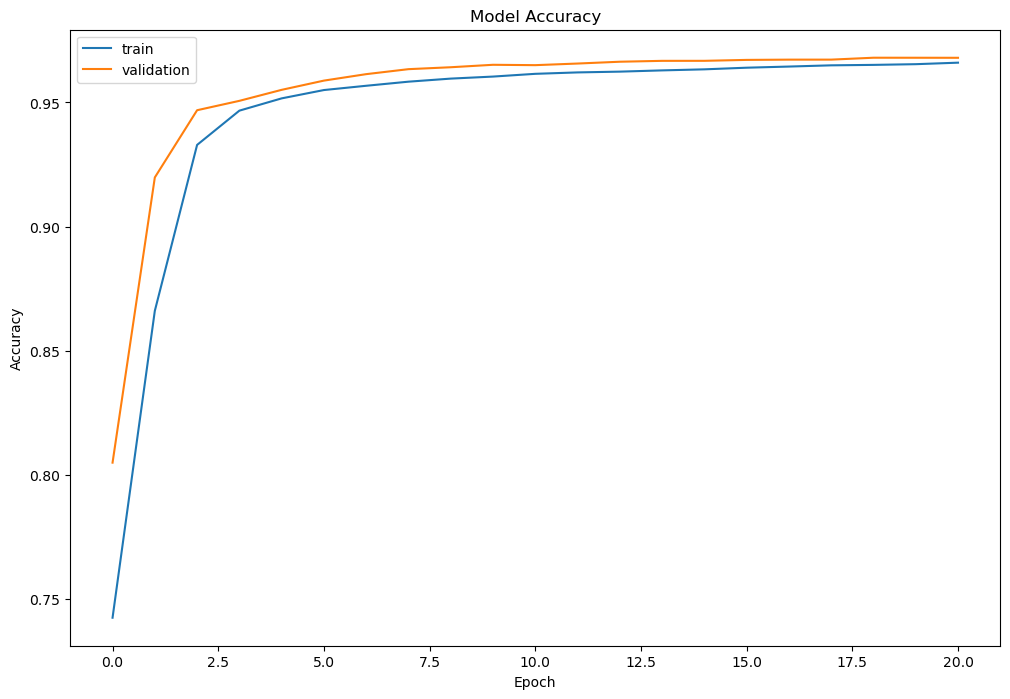

In [93]:
df_loss_acc = pd.DataFrame(history.history)

df_loss = df_loss_acc[['loss', 'val_loss']].copy()
df_loss.rename(columns={'loss': 'train', 'val_loss': 'validation'}, inplace=True)

df_acc = df_loss_acc[['accuracy', 'val_accuracy']].copy()
df_acc.rename(columns={'accuracy': 'train', 'val_accuracy': 'validation'}, inplace=True)

# Plotting
df_loss.plot(title='Model Loss', figsize=(12, 8)).set(xlabel='Epoch', ylabel='Loss')
df_acc.plot(title='Model Accuracy', figsize=(12, 8)).set(xlabel='Epoch', ylabel='Accuracy');


## Test the model Visually

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step 


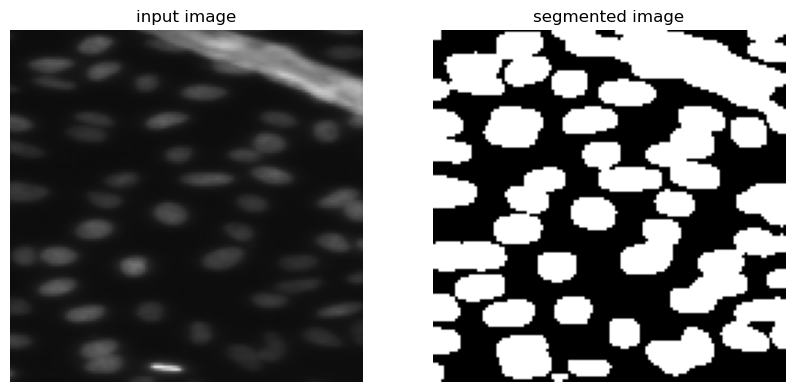

In [102]:
preds_test = model.predict(X_test, verbose=1)
preds_test_threshold = (preds_test > 0.5).astype(np.uint8)

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
ind = np.random.randint(0, len(test_ids))
axes[0].imshow(X_test[ind])
axes[0].set_title('input image')
axes[0].axis('off')

axes[1].imshow(preds_test_threshold[ind], cmap='gray')
axes[1].set_title('segmented image')
axes[1].axis('off');